# Interactive network creation

## Imports

In [1120]:
import os
import cv2
import threading
import time
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import imageio
import random
import sqlite3
import itertools
import json
import shutil
import ntpath
import math
import requests
import seaborn as sns
import pandas as pd
import tikzplotlib

from time import sleep
from datetime import datetime
from random import randint
from random import randrange
import holoviews as hv
from holoviews import opts, dim
from datetime import datetime

In [2]:
from pyvis.network import Network
import json

In [589]:
with open('../iconclass_dic.pkl', 'rb') as handle:
    iconclass_dic = pickle.load(handle)
#Adding missing category
iconclass_dic['11HH'] = 'female saints'

In [819]:
df_hands_clusters = pd.read_csv('df_hands_clusters.csv', index_col = 0)
df_hands_clusters_flipped = pd.read_csv('df_hands_clusters_flipped.csv', index_col = 0)

In [647]:
DB_df_ = pd.read_csv('DB_df_keywords_DE_4th_degree_update_07_2023.csv',index_col=0)

In [648]:
DB_df_.head(3)

,index,object_ID,title,artist_GND,artist_name,date_begin,date_end,current_location,type,medium,dimensions,img_digital,century,id,keywords,iconography_main,iconography
54,54,8055384,Die Heiligen Scholastika und Benedikt empfange...,ulan500017301 & gnd123097843,Paolo de Matteis,1685.0,1725.0,Cava de' Tirreni,Gemälde,Öl,225 x 180 cm,bhim00035651,1650.0,bhim00035651_2_hand_right.jpg,"[[('11H(', 836), ('11HH', 614), ('11I6', 61), ...",11H,saints
87,87,8028831,Madonna del Soccorso,unknown,Niccolò di Liberatore di Giacomo di Mariano,1497.0,1497.0,unknown,Gemälde,Tempera & Leinwand,150 x 107 cm,bhim00017285,1450.0,bhim00017285_0_hand_left.jpg,"[[('11F', 136), ('11H', 14), ('94L', 6), ('94F...",11F,the Virgin Mary
93,93,8088949,Bauern an der Tränke,ulan500007713 & gnd136667031,Michelangelo Cerquozzi,1620.0,1660.0,unknown,Gemälde,Öl,"51 x 44,5 cm",bhim00036067,1600.0,bhim00036067_1_hand_left.jpg,"[[('47I', 115), ('47G', 70), ('11H', 41), ('71...",47I,"agriculture, cattle-breeding, horticulture, fl..."


In [649]:
count_icon_df_ = DB_df_.groupby(['img_digital', 'iconography_main', 'iconography'], as_index=False, dropna=False).size()

In [650]:
unique_icon = count_icon_df_['iconography'].unique()

In [651]:
len(unique_icon)

89

In [652]:
for icon_ in unique_icon:
    print(icon_, count_icon_df_.loc[count_icon_df_['iconography']== icon_]['iconography_main'].values[0], len(count_icon_df_.loc[count_icon_df_['iconography'] == icon_]))

male persons from classical history 98B 97
the arts; artists 48C 28
saints 11H 1105
(scenes from the life of) John the Baptist and Mary 73A 51
public life of Christ: from his baptism until the Passion 73C 181
gods of the earth and fertility ~ life in mountains and woods 92L 18
female saints 11HH 252
the Virgin Mary 11F 144
Genesis: the patriarchs 71C 19
birth and youth of Christ 73B 25
Passion of Christ 73D 58
lesser divinities of Heaven ~ serving and attendant environment 92D 20
the worship of God 11Q 15
the great goddesses of Heaven, and their train 92C 23
sports, games and physical performances 43C 9
Exodus, Leviticus, Numbers, Deuteronomy, Joshua: from the bondage of the Israelites in Egypt to their settlement in Canaan 71E 13
prophets, sibyls, evangelists, Doctors of the Church; persons ~ the Bible (not in biblical context) 11I 29
female persons from classical history 98C 6
Genesis: the story of Joseph 71D 13
the book of Tobit 71T 11
medicine, medical science 49G 1
the divided kin

### Remove a degree for iconographies
The idea is to remove a degree if the iconography is not represented more than 10 times

In [653]:
icons_original = []
icons_convert = []
for icon_ in unique_icon:
    icon_id = count_icon_df_.loc[count_icon_df_['iconography']== icon_]['iconography_main'].values[0]
    icon_tot =  len(count_icon_df_.loc[count_icon_df_['iconography'] == icon_])
    if icon_id ==  'None':
        continue
    if icon_tot < 10:
        icons_original.append(icon_id)
        icons_convert.append(icon_id[:-1])
    else:
        icons_original.append(icon_id)
        icons_convert.append(icon_id)

In [654]:
icons_convert_df = pd.DataFrame(zip(icons_original, icons_convert), columns=['original', 'convert'])

In [655]:
icons_convert_df

,original,convert
0,98B,98B
1,48C,48C
2,11H,11H
3,73A,73A
4,73C,73C
...,...,...
83,11R,11
84,94I,94
85,91E,91
86,71O,71


In [656]:
#Create again an iconclass dic to get names of the classes for the 4th and 2nd degree
#Yet, note that only the third level is mainted, except for 11HH which represents 'female saints'
iconclass_dic_4 = {}

for index, row in icons_convert_df.iterrows():
    
    key = row['convert']

    if key in iconclass_dic_4:
        continue

    icon_url = f"https://iconclass.org/{key.replace('(', '')}.jskos"

    r =requests.get(icon_url)

    site_json=json.loads(r.text) 
    
    iconclass_dic_4[key] = site_json['prefLabel'].get('en')

In [657]:
DB_df_iconogaphies_2_degree = DB_df_.copy()

In [660]:
iconography_main = []
iconography_name = []

for i, row in DB_df_.iterrows():
    icon_main_ = row['iconography_main']
    
    if icon_main_ == 'None':
        iconography_main.append('None')
        iconography_name.append('None')
        continue
        
    icon_convert = icons_convert_df.loc[icons_convert_df['original'] == icon_main_]['convert'].values[0]
    icon_name_ = iconclass_dic_4[icon_convert]
    
    iconography_main.append(icon_convert)
    iconography_name.append(icon_name_)

In [661]:
DB_df_iconogaphies_2_degree['iconography_main'] = iconography_main
DB_df_iconogaphies_2_degree['iconography'] = iconography_name

In [662]:
DB_df_iconogaphies_2_degree.head(3)

,index,object_ID,title,artist_GND,artist_name,date_begin,date_end,current_location,type,medium,dimensions,img_digital,century,id,keywords,iconography_main,iconography
54,54,8055384,Die Heiligen Scholastika und Benedikt empfange...,ulan500017301 & gnd123097843,Paolo de Matteis,1685.0,1725.0,Cava de' Tirreni,Gemälde,Öl,225 x 180 cm,bhim00035651,1650.0,bhim00035651_2_hand_right.jpg,"[[('11H(', 836), ('11HH', 614), ('11I6', 61), ...",11H,saints
87,87,8028831,Madonna del Soccorso,unknown,Niccolò di Liberatore di Giacomo di Mariano,1497.0,1497.0,unknown,Gemälde,Tempera & Leinwand,150 x 107 cm,bhim00017285,1450.0,bhim00017285_0_hand_left.jpg,"[[('11F', 136), ('11H', 14), ('94L', 6), ('94F...",11F,the Virgin Mary
93,93,8088949,Bauern an der Tränke,ulan500007713 & gnd136667031,Michelangelo Cerquozzi,1620.0,1660.0,unknown,Gemälde,Öl,"51 x 44,5 cm",bhim00036067,1600.0,bhim00036067_1_hand_left.jpg,"[[('47I', 115), ('47G', 70), ('11H', 41), ('71...",47,crafts and industries


In [663]:
#DB_df_iconogaphies_2_degree.to_csv('DB_df_keywords_DE_2nd_degree_update_08_2023.csv')

In [820]:
DB_df_ = pd.read_csv('DB_df_keywords_DE_2nd_degree_update_08_2023.csv',index_col=0)

## Functions definition

In [1078]:
def write_html(nodes_, edges_, title="network_"):
    nx_template=  f"""
        <html>
            <head>
            <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/vis/4.16.1/vis.css" type="text/css" />
            <script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/vis/4.16.1/vis-network.min.js"> </script>
            <center>
            <h1></h1>
            </center>

            <!-- <link rel="stylesheet" href="../node_modules/vis/dist/vis.min.css" type="text/css" />
            <script type="text/javascript" src="../node_modules/vis/dist/vis.js"> </script>-->

            <style type="text/css">
              #mynetwork {{
                  width: 100%;
                  height: 1080px;
                  background-color: #222222;
                  border: 0px solid lightgray;
                  position: relative;
                  float: left;
              }}
              /* The sidebar menu */
              .sidebar {{
                height: 100%; /* 100% Full-height */
                width: 0; /* 0 width - change this with JavaScript */
                position: fixed; /* Stay in place */
                z-index: 1; /* Stay on top */
                top: 0;
                left: 0;
                background-color: rgba(255, 255, 255, 0.3);/*background-color: #111; /* Black*/
                overflow-x: hidden; /* Disable horizontal scroll */
                padding-top: 60px; /* Place content 60px from the top */
                transition: 0.5s; /* 0.5 second transition effect to slide in the sidebar */
              }}

              /* The sidebar links */
              .sidebar a {{
                padding: 8px 8px 8px 32px;
                text-decoration: none;
                font-size: 25px;
                color: #818181;
                display: block;
                transition: 0.3s;
              }}

              /* When you mouse over the navigation links, change their color */
              .sidebar a:hover {{
                color: #f1f1f1;
              }}

              /* Position and style the close button (top right corner) */
              .sidebar .closebtn {{
                position: absolute;
                top: 0;
                right: 25px;
                font-size: 36px;
                margin-left: 50px;
              }}

              /* The button used to open the sidebar */
              .openbtn {{
                position: fixed;
                top: 0;
                left: 0;
                z-index: 1;
                font-size: 20px;
                cursor: pointer;
                background-color: #111;
                color: white;
                padding: 10px 15px;
                border: none;
              }}

              .openbtn:hover {{
                background-color: #444;
              }}

              /* Style page content - use this if you want to push the page content to the right when you open the side navigation */
              #mynetwork {{
                transition: margin-left .5s; /* If you want a transition effect */
                padding: 20px;
              }}

              #clusterimage{{
                bottom:0;
                right: 0;
                z-index: 1;
                position: fixed;
                max-width: 2000px;
                transition: 0.5s;
                display: none;
              }}
              
              .inner {{
                  margin-left: 50px;
                  background-color: orange;
                }}
            </style>

            </head>

            <body>
            <button class="openbtn" onclick="openNav()">&#9776; Iconography</button>
            <div id = "mynetwork"></div>
            <div id="mySidebar" class="sidebar">
              <a href="javascript:void(0)" class="closebtn" onclick="closeNav()">&times;</a>
              <div id="group" style="z-index : 50; position:absolute; left:20; top:50; color: white; width: 500px; height: 800px; overflow-y: scroll;">
              </div>
            </div>
            <img id="clusterimage" src=""/>
            <script type="text/javascript">

                // initialize global variables.
                var edges;
                var nodes;
                var network;
                var container;
                var options, data;

                var edges_icon;



                // parsing and collecting nodes and edges from the python
                nodes = new vis.DataSet({nodes_});
                edges = new vis.DataSet({edges_});
                // This method is responsible for drawing the graph, returns the drawn network
                function drawGraph(nodes_, edges_, centralGravity) {{
                    console.log("Drawing graph")
                    console.log(nodes_)
                    console.log(edges_)
                    var container = document.getElementById('mynetwork');
                    // adding nodes and edges to the graph
                    data = {{nodes: nodes_, edges: edges_}};

                    var options = {{
                      "configure": {{
                          "enabled": false
                      }},
                      "edges": {{
                          "color": {{
                              "inherit": true,
                              "opacity": 0.5,
                          }},
                          "smooth": {{
                              "enabled": false,
                              "type": "continuous"
                          }}
                      }},
                      "interaction": {{
                          "dragNodes": true,
                          "hideEdgesOnDrag": false,
                          "hideNodesOnDrag": false
                      }},
                      "physics": {{
                          "barnesHut": {{
                              "avoidOverlap": 0,
                              "centralGravity": centralGravity,
                              "damping": 0.09,
                              "gravitationalConstant": -80000,
                              "springConstant": 0.001,
                              "springLength": 250
                          }},
                          "enabled": true,
                          "stabilization": {{
                              "enabled": true,
                              "fit": true,
                              "iterations": 1000,
                              "onlyDynamicEdges": false,
                              "updateInterval": 50
                          }}
                      }}
                  }};

                  network = new vis.Network(container, data, options);

                  network.on( 'release', function(properties) {{
                    document.getElementById("clusterimage").style.display = "none";
                    document.getElementById("clusterimage").src = "";
                  }});

                  return network;
                }}

                function hideEdges(node_id){{
                  let hide_edges = edges.get({{
                    filter: function (item) {{
                      from_ = item.from
                      to_ = item.to
                      my_label = String(item.title);
                      if (item.from === node_id) {{
                        return false;
                      }} else if (item.to === node_id) {{
                        return false;
                      }} else {{
                        return true;
                      }}
                    }}
                  }});
                  return hide_edges;
                }}

                drawGraph(nodes, edges, 0.3);

                var edge_name = [];

                edge_names_ =  edges.get({{fields: ['title']}})

                for (const edge of edge_names_) {{
                  edge_name.indexOf(edge.title) === -1 ? edge_name.push(edge.title) : null;
                }}
                
                // sort the names in alphabetical order
                edge_name.sort()

                // generate the radio groups
                const group = document.querySelector("#group");
            
                //Try here to build innerHTML for checkboxes with indent for inner iconographies
                checkbox_innerHTML =  "" 
                
                for (const i in edge_name) {{
                    edge = edge_name[i]
                    icon = edge.split("|")[0]

                    if (icon.length > 3){{
                        console.log("Icon length is bigger than")
                        checkbox_innerHTML += `<div class="inner">
                            <input type="checkbox" name="edge" value="${{edge}}" id="${{edge}}">
                             <label for="${{edge}}">${{edge}}</label>
                        </div>`
                    }} else {{
                        checkbox_innerHTML += `<div>
                            <input type="checkbox" name="edge" value="${{edge}}" id="${{edge}}">
                             <label for="${{edge}}">${{edge}}</label>
                        </div>`
                    }}
                }}
                
                group.innerHTML = checkbox_innerHTML
                
                //
                //group.innerHTML = edge_name.map((edge) => `<div>
                //        <input type="checkbox" name="edge" value="${{edge}}" id="${{edge}}">
                //         <label for="${{edge}}">${{edge}}</label>
                //    </div>`).join(' ');

                group.innerHTML += '<div> <input type="checkbox" name="edge" value="all" id="all"><label for="all">all</label> </div>';
                // add an event listener for the change event
                const radioButtons = document.querySelectorAll('input[name="edge"]');

                for(const radioButton of radioButtons){{
                    radioButton.addEventListener('change', showSelected);
                }}

                function showSelected(e) {{

                    let checkboxes = document.querySelectorAll('input[name="edge"]:checked');
                    let values = [];
                    checkboxes.forEach((checkbox) => {{
                        values.push(String(checkbox.value));
                    }});
                    console.log(values);

                    //if (this.checked) {{
                    check_value = String(this.value);
                    allNodes = nodes.get({{
                      returnType: "Object"
                    }});

                    if (check_value === 'all') {{
                      drawGraph(nodes, edges, 0.3);
                    }}else{{

                      let nodes_show = new Set();
                      //let jsondata = JSON.parse(edges_icon);
                      //console.log(jsondata.edges)
                      //console.log(jsondata.edges);
                      /*var json = $.getJSON("data.json").done(function(data){{
                        edges_icon: data.edges
                      }});*/
                      //console.log(edges_icon)

                      let keep_edges = edges.get({{//edges_icon.get({{
                        filter: function (item) {{
                          my_label = String(item.title);
                          //console.log(my_label);
                          for (const checked of values){{
                            if (my_label === checked) {{
                              return my_label === checked;
                            }}
                          }}
                          return false;
                        }}
                      }});


                      for (const edge of keep_edges){{
                        nodes_show.add(edge.from);
                        nodes_show.add(edge.to);
                      }};

                      let keep_nodes = nodes.get({{
                        filter: function (item) {{
                          my_item = item.id
                          return nodes_show.has(my_item);
                        }}
                      }});
                      let gravity = 1;

                      drawGraph(new vis.DataSet(keep_nodes), new vis.DataSet(keep_edges), gravity);
                      console.log(`You selected ${{this.value}}`);

                    }}
                    console.log(`You selected ${{this.value}}`);
                }}

                //SIDE BAR
                /* Set the width of the sidebar to 250px and the left margin of the page content to 250px */
                function openNav() {{
                  document.getElementById("mySidebar").style.width = "500px";
                  //document.getElementById("main").style.marginLeft = "250px";
                }}

                /* Set the width of the sidebar to 0 and the left margin of the page content to 0 */
                function closeNav() {{
                  document.getElementById("mySidebar").style.width = "0";
                  //document.getElementById("main").style.marginLeft = "0";
                }}

            </script>
            </body>
        </html>
        """
    # datetime object containing current date and time
    now = datetime.now()

    # dd/mm/YY H:M:S
    dt_string = now.strftime("%d_%m_%Y_%H_%M_%S.html")
    # Creating the HTML file
    file_html = open(title+dt_string, "w")
    # Adding the input data to the HTML file
    file_html.write(nx_template)
    # Saving the data into the HTML file
    file_html.close()

In [460]:
def createNetwork_simple(html_path, node_df__, edge_df__):
    net = Network(height='1050px', width='100%', neighborhood_highlight=True, bgcolor='#222222', font_color='white')#, select_menu=True)#font_color='white')
    net.barnes_hut()
    #net.force_atlas_2based(overlap=1)#, timestep=0.03)
    net.set_edge_smooth('dynamic')
    count=0
    edges_ = '['
    #edge_df__ = edge_df__.astype({"weight_edge": int})
    nodes_name = node_df["name"].tolist()

    for i, node in node_df__.iterrows():
        color_ = color[i]
        net.add_node(node['name'], shape="circularImage", 
                     image="KMEANS_features_alkashi_scaled_flipped_40_clusters/"+str(i)+".jpg", 
                     size=node['weight_cluster'], labelHighlightBold=True, title=str(node['name']), 
                     color=color_) #label=node['name'],
    
    for i, edge in edge_df__.iterrows():
        from_ = edge['source'].astype(str)
        to_ = edge['target'].astype(str)
        value_ = edge['weight_edge'].astype(str)
        color_ = color[nodes_name.index(to_)]
        # Data to be written
        if to_ != '-1':
            new_edge = '{"from":'+from_+',"to":'+to_+',"value":'+value_+'"},'
            edges_+=new_edge
            #write_json(new_edge)
            net.add_edge(from_, to_, value=value_, opacity=1, image=image_, color=color_)
    edges_+=']'
   """ 
   with open('data.txt', 'w') as f:
        f.write(edges_)
    with open("data.json", "w") as write_file:
        json.dump(edges_, write_file)"""
    #net.show_buttons(filter_=['physics'])
    #net.toggle_hide_edges_on_drag(True)
    net.show(html_path)

In [ ]:
def createNetwork(html_path, node_df__, edge_df__, img_path="KMEANS_features_alkashi_scaled_flipped_40_clusters/", flipped=False):
    net = Network(height='1050px', width='100%', neighborhood_highlight=True, bgcolor='#222222', font_color='white')#, select_menu=True)#font_color='white')
    net.barnes_hut()
    #net.force_atlas_2based(overlap=1)#, timestep=0.03)
    net.set_edge_smooth('dynamic')
    count=0
    edges_ = '['
    nodes_ = '['
    #edge_df__ = edge_df__.astype({"weight_edge": int})
    icon_name = edge_df__['icon_name'].unique().tolist()

    for i, node in node_df__.iterrows():
        if flipped:
            image_ = img_path+str(i)+"_l_r.jpg"
        else:
            image_ = img_path+str(i)+".jpg"
        label_ = str(node['name'])
        size_ = node['weight_cluster']
        title_ = str(node['name'])
        
        net.add_node(node['name'], label=label_, shape="circularImage", image=image_, size=size_, 
                     labelHighlightBold=True, title=title_) #label=node['name'],
        new_node = f'''{{"color": "#97c2fc", "font": {{"color": "white"}}, "id": "{label_}", "image": "{image_}", "label": "{label_}", "labelHighlightBold": true, "shape": "circularImage", "size": {size_}, "title": "{title_}"}},'''
        nodes_ += new_node
    
    for i, edge in edge_df__.iterrows():
        from_ = edge['source']
        to_ = edge['target']
        value_ = edge['weight_edge']
        icon_ = edge['icon_name']
        title_ = f"{edge['icon']} | {icon_}"
        color_ = color[icon_name.index(icon_)]
        # Data to be written
        if to_ != '-1':
            new_edge = '{"from":'+str(from_)+',"to":'+str(to_)+',"value":'+str(value_)+',"title":"'+title_+'","color":"'+str(color_)+'"},'
            edges_+=new_edge
            #write_json(new_edge)
            net.add_edge(from_, to_, value=value_*10, opacity=1, image=image_, title=icon_, color=color_)
    edges_+=']'
    nodes_+=']'
    
    write_html(nodes_, edges_, html_path.replace('.html', '_'))
    #et.show(html_path)

In [1092]:
def createNetwork(html_path, node_df__, edge_df__, img_path="KMEANS_features_alkashi_scaled_flipped_40_clusters/", flipped=False):
    net = Network(height='1050px', width='100%', neighborhood_highlight=True, bgcolor='#222222', font_color='white')#, select_menu=True)#font_color='white')
    net.barnes_hut()
    #net.force_atlas_2based(overlap=1)#, timestep=0.03)
    net.set_edge_smooth('dynamic')
    count=0
    edges_ = '['
    nodes_ = '['
    #edge_df__ = edge_df__.astype({"weight_edge": int})
    icon_name = edge_df__['icon_name'].unique().tolist()

    for i, node in node_df__.iterrows():
        if flipped:
            image_ = img_path+str(node['id'])+"_l_r.jpg"
            if int(node['id']) >= 40 :
                shape_ = "circularImage"
            else:
                shape_ = "circularImage"
        else:
            image_ = img_path+str(node['id'])+".jpg"
            shape_ = "circularImage"
            
        label_ = str(node['name'])
        size_ = node['weight_cluster']
        title_ = str(node['name'])
        
        net.add_node(node['name'], label=label_, shape="circularImage", image=image_, size=size_, 
                     labelHighlightBold=True, title=title_) #label=node['name'],
        new_node = f'''{{"color": "#97c2fc", "font": {{"color": "white"}}, "id": "{label_}", "image": "{image_}", "label": "{label_}", "labelHighlightBold": true, "shape": "{shape_}", "size": {size_}, "title": "{title_}"}},'''
        nodes_ += new_node
    
    for i, edge in edge_df__.iterrows():
        from_ = edge['source']
        to_ = edge['target']
        value_ = edge['weight_edge']
        icon_ = edge['icon_name']
        title_ = f"{edge['icon']} | {icon_}"
        color_ = color[icon_name.index(icon_)]
        # Data to be written
        if to_ != '-1':
            new_edge = '{"from":"'+str(from_)+'","to":"'+str(to_)+'","value":'+str(value_)+',"title":"'+title_+'","color":"'+str(color_)+'"},'
            edges_+=new_edge
            #write_json(new_edge)
            net.add_edge(from_, to_, value=value_*10, opacity=1, image=image_, title=icon_, color=color_)
    edges_+=']'
    nodes_+=']'
    
    write_html(nodes_, edges_, html_path.replace('.html', '_'))
    #et.show(html_path)

In [854]:
def getIconography(df_hands_clusters_):
    hands_icon = []
    names_icon = []
    for index, row in df_hands_clusters_flipped.iterrows():
        #get the corresponding iconography of the hand image
        icon_main = DB_df_.loc[DB_df_['id'] == row['hands']]['iconography_main']
        icon_name = DB_df_.loc[DB_df_['id'] == row['hands']]['iconography']
        if len(icon_main)>1: #sometimes more than one item is found
            icon = icon_main.iat[0]
            name_ = icon_name.iat[0]
        else:
            icon = icon_main.item()
            name_ = icon_name.item()
        hands_icon.append(icon)
        names_icon.append(name_)
        
    return hands_icon, names_icon

def createHandsCombination(df_hands_clusters_):
    #Here we get the hand combinations for each painting
    hands_combination = {}

    for i, row in df_hands_clusters_.iterrows():
        img_digital =  row['hands'].split('_')[0]
        cluster = row['cluster']

        if img_digital in hands_combination:
            hands_combination[img_digital].append(cluster)
        else:
            hands_combination[img_digital] = [cluster]

    #sort the combinations
    for key, item in hands_combination.items():
        hands_combination[key] = sorted(item)
        
    return hands_combination

def prepareNetwork(hands_combination_, df_hands_clusters_, nonetype='-1'):
    #We then group the hand combinations according to iconography                    
    from_ = []
    to_ = []
    icon_ = []
    icon_name_ = []

    for key, combination in hands_combination_.items():
        icon = df_hands_clusters_.loc[df_hands_clusters_['hands'].str.contains(key), 'iconography'].values[0]
        icon_name = df_hands_clusters_.loc[df_hands_clusters_['hands'].str.contains(key), 'icon_name'].values[0]

        for idx, a in enumerate(combination):
            if len(combination) == 1:
                icon_name_.append(icon_name)
                icon_.append(icon)
                from_.append(a)
                to_.append(nonetype)
            else:
                for b in combination[idx + 1:]:
                    icon_name_.append(icon_name)
                    icon_.append(icon)
                    from_.append(a)
                    to_.append(b)
                    
    return from_, to_, icon_, icon_name_

In [1104]:
def min_max_scaling(column):
    return (column - column.min()) / (column.max() - column.min())*100

## Prepare data - flipped hands

### Hands combinations

In [923]:
hands_icon, names_icon = getIconography(df_hands_clusters_flipped)

In [924]:
df_hands_clusters_flipped['iconography'] = hands_icon
df_hands_clusters_flipped['icon_name'] = names_icon

In [925]:
df_hands_clusters_flipped.head(4)

,hands,cluster,iconography,icon_name
0,bhim00037788_0_hand_right.jpg,26,11HH,female saints
1,bh012186_0_hand_right.jpg,5,11H,saints
2,bh013263_0_hand_right.jpg,36,11H,saints
3,bhim00037212_1_hand_right.jpg,33,42,"family, descendance"


In [926]:
print("Amount of different iconographies represented:", len(df_hands_clusters_flipped['icon_name'].unique()))

Amount of different iconographies represented: 57


In [927]:
hands_combination = createHandsCombination(df_hands_clusters_flipped)

In [928]:
hands_combination

{'bhim00037788': [5, 26],
 'bh012186': [5],
 'bh013263': [35, 36],
 'bhim00037212': [2, 12, 13, 17, 24, 32, 33],
 'bh012634': [25],
 'bhim00024287': [24],
 'bhim00017456': [8],
 'bh052628': [1, 8],
 'bhim00033989': [12],
 'bh000775': [3, 3, 4],
 'bh013546': [9, 13, 31],
 'bh013200': [11, 14, 21, 24],
 'bh013091': [10, 13, 20, 28, 28],
 'bhim00037058': [4, 8, 12, 16, 21, 30, 35],
 'bh012280': [26, 26],
 'bh001533': [25],
 'bh002586': [15, 24, 25, 26, 30, 31],
 'bhim00038638': [17],
 'bh013276': [8],
 'bh209938': [5, 23, 37],
 'bhpd68259': [27, 33],
 'bhim00027728': [7, 15, 31],
 'bhim00017324': [8, 16, 16, 33],
 'bhim00037841': [11, 21, 21, 21, 22, 23],
 'bh012257': [21],
 'bh000889': [31, 35],
 'bhim00038652': [10, 33, 35],
 'bhped65793': [1, 37],
 'bh012233': [28, 29],
 'bhpeb70657': [1, 2, 10, 15, 35],
 'bh001987': [8, 8],
 'bhim00017466': [9, 17],
 'bhim00028070': [10, 11, 25],
 'bhim00033973': [6, 31, 31],
 'bh012093': [24],
 'bh001935': [1, 3],
 'bh000861': [1, 31, 33],
 'bh000450

In [929]:
from_, to_, icon_, icon_name_ = prepareNetwork(hands_combination, df_hands_clusters)

In [930]:
df_combinations = pd.DataFrame({'iconography': icon_, 'from': from_, 'to': to_})

In [931]:
df_combinations_simple = pd.DataFrame({'from': from_, 'to': to_})

### Plot heatmap

In [809]:
counter_df_ = df_combinations_simple.groupby(df_combinations_simple.columns.tolist(), as_index=False, dropna=False).size()

In [814]:
counter_df_ = counter_df_.fillna('None')

In [769]:
heatmap_df_ = counter_df_.pivot_table(index='from', columns='to', values='size', fill_value=0, dropna=False)

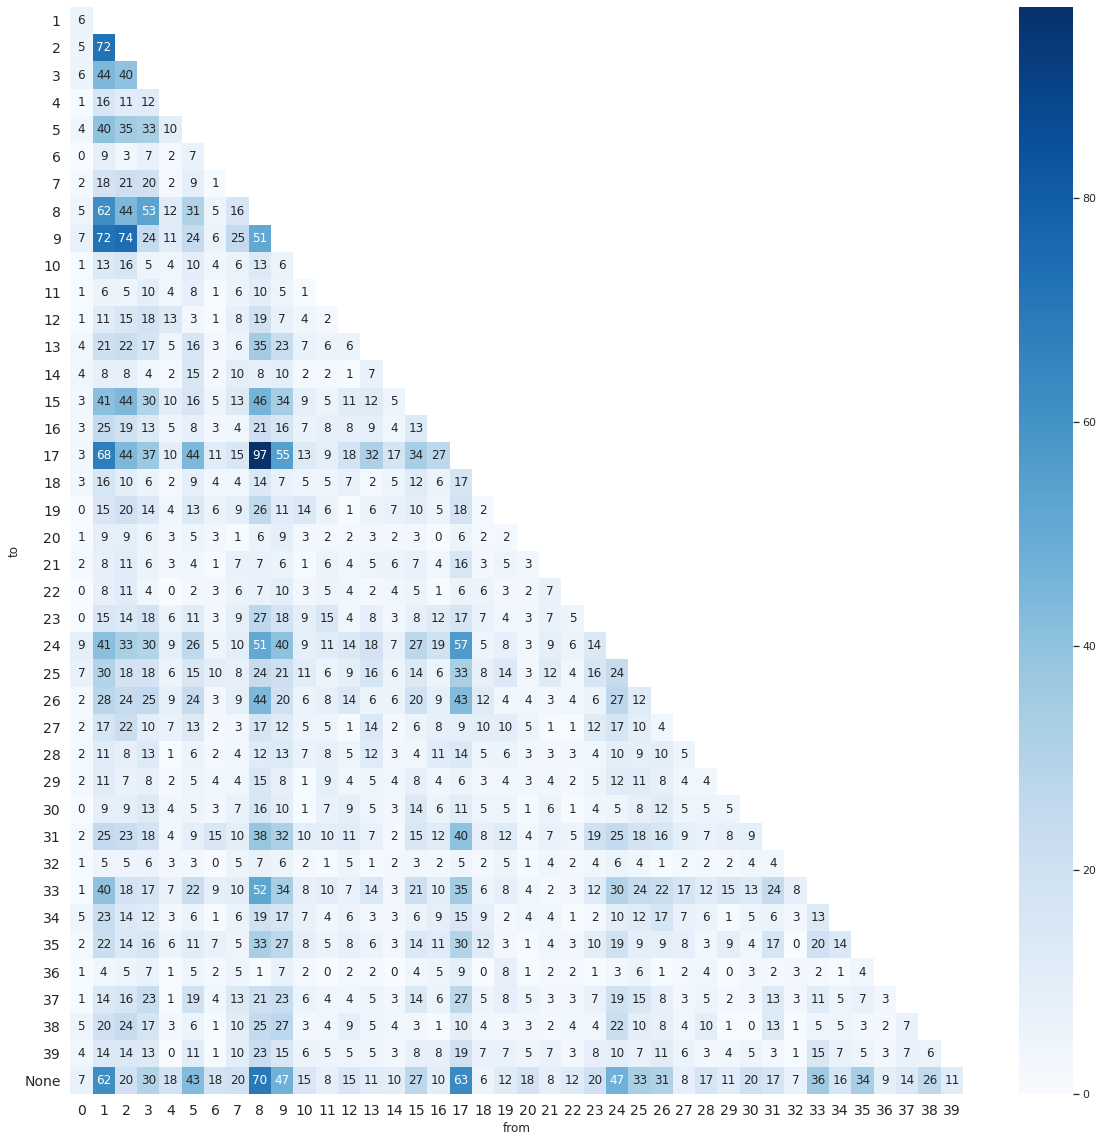

In [789]:
fig, ax = plt.subplots(figsize=(20,20)) 
mask = np.triu(np.ones_like(heatmap_df_, dtype=bool), 1)
b = sns.heatmap(heatmap_df_.T, mask=mask, cmap="Blues", annot=True)
b.tick_params(labelsize=14)
ax.tick_params(axis='y', rotation=0)
ax.set_facecolor("white")
plt.savefig('hands_flipped_combination_heatmap_.png', dpi=150)

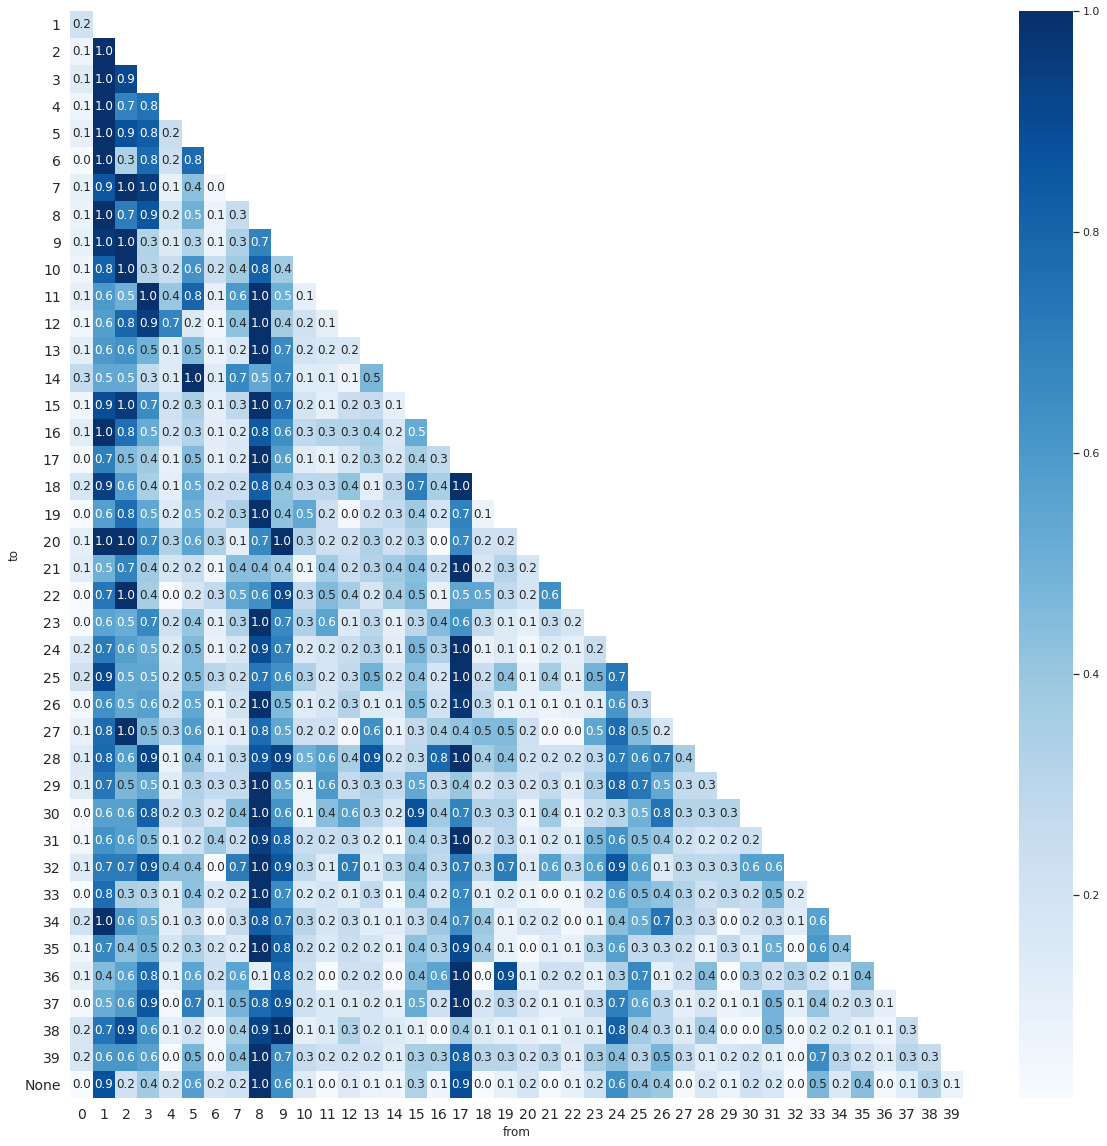

In [786]:
#Try with normalisation
#df_norm_col=(heatmap_df_-heatmap_df_.mean())/heatmap_df_.std()
df_norm_col=(heatmap_df_-heatmap_df_.min())/(heatmap_df_.max()-heatmap_df_.min())

fig, ax = plt.subplots(figsize=(20,20)) 

# Create a mask
mask = np.triu(np.ones_like(heatmap_df_, dtype=bool), 1)

b = sns.heatmap(df_norm_col.T, mask=mask, cmap="Blues", annot=True,robust=True, fmt='.1f')

b.tick_params(labelsize=14)
ax.tick_params(axis='y', rotation=0)
ax.set_facecolor("white")

plt.savefig('hands_flipped_combination_heatmap_normalisation.png', dpi=150)

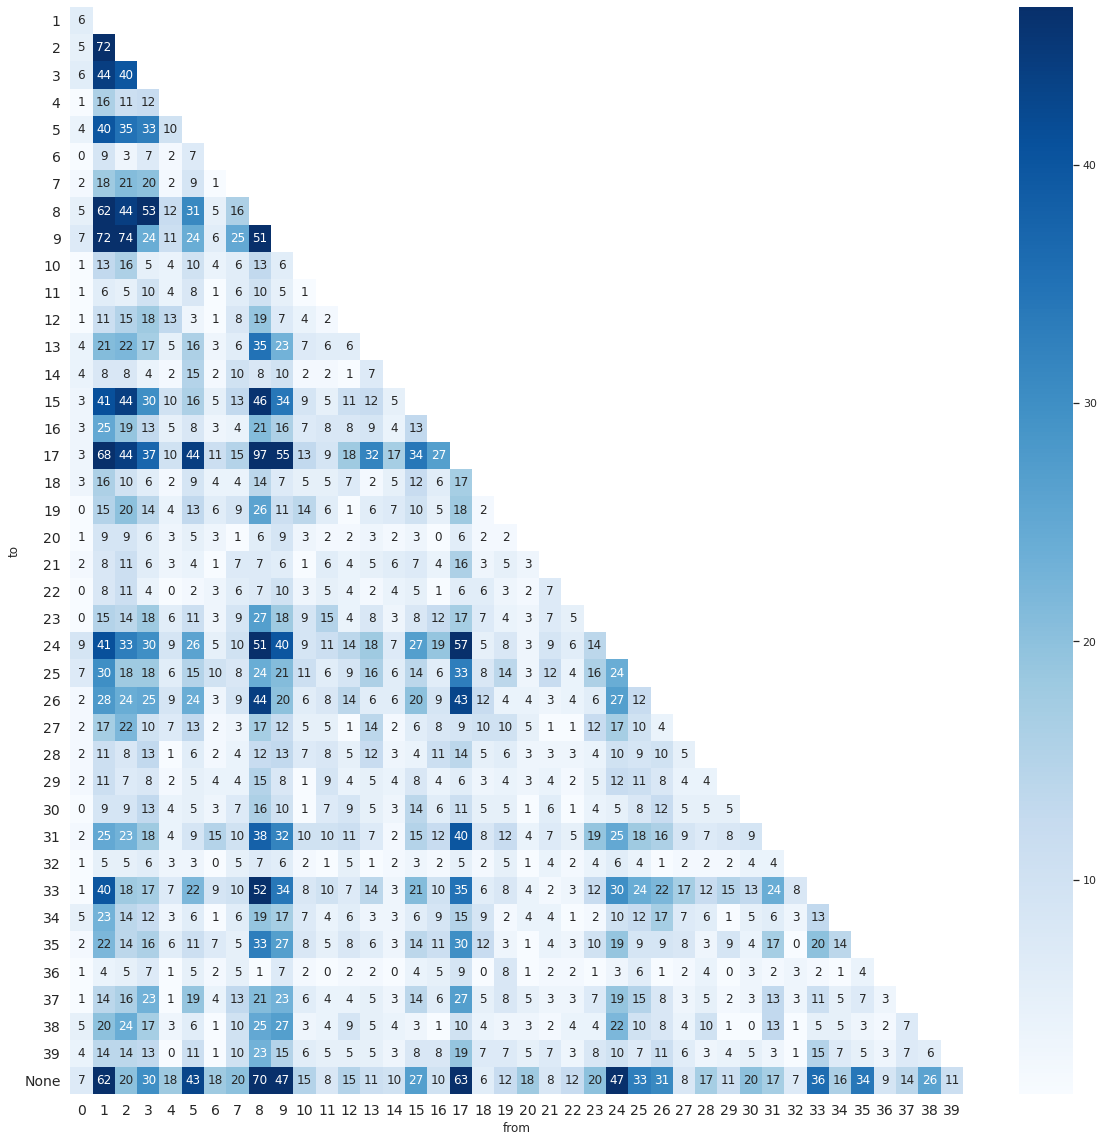

In [818]:
fig, ax = plt.subplots(figsize=(20,20)) 


# Create a mask
mask = np.triu(np.ones_like(heatmap_df_, dtype=bool), 1)

b = sns.heatmap(heatmap_df_.T, mask=mask, cmap="Blues", annot=True,robust=True)

b.tick_params(labelsize=14)
ax.tick_params(axis='y', rotation=0)
ax.set_facecolor("white")

plt.savefig('hands_flipped_combination_heatmap_robust_quantiles.png')

### Plot chord map

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
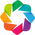

In [93]:
hv.extension('bokeh')
hv.output(size=200)

In [673]:
#We then group the hand combinations according to iconography
from_ = []
to_ = []
for key, combination in hands_combination.items():
    icon = df_hands_clusters_flipped.loc[df_hands_clusters_flipped['hands'].str.contains(key), 'iconography'].values[0]
    for idx, a in enumerate(combination):
        if len(combination) == 1:
            from_.append(a)
            to_.append(-1)
        else:
            for b in combination[idx + 1:]:
                from_.append(a)
                to_.append(b)

In [106]:
chord_df_ = pd.DataFrame(list(zip(from_, to_)),columns=['source', 'target']) #source #target

In [112]:
counter_df_ = chord_df_ .groupby(chord_df_ .columns.tolist(), as_index=False, dropna=False).size()

In [116]:
counter_df_.rename(columns = {'size':'value'}, inplace = True)

In [141]:
counter_df_ = counter_df_.sort_values('value',ascending=False)

In [152]:
counter_df_ = counter_df_.astype({'source':'string','target':'string'})

In [174]:
chord_df_= chord_df_.astype({'source':'string','target':'string'})

In [672]:
#non conclusive results
#chord = hv.Chord(chord_df_)
#chord.opts(cmap='Category20', edge_cmap='Category20', edge_color='source', label_index='index', node_color='source')

### Create an edge dataframe

In [932]:
edge_df_ = pd.DataFrame(list(zip(from_, to_)),columns=['source', 'target']) #source #target

In [933]:
edge_df_.head()

,source,target
0,5,26
1,5,-1
2,35,36
3,2,12
4,2,13


In [934]:
edge_df_ = edge_df_ .groupby(edge_df_ .columns.tolist(), as_index=False, dropna=False).size()

In [935]:
edge_df_.rename(columns = {'size':'weight_edge'}, inplace = True)

In [936]:
edge_df_

,source,target,weight_edge
0,0,1,6
1,0,2,5
2,0,3,6
3,0,4,1
4,0,5,4
...,...,...,...
834,38,38,8
835,38,39,6
836,38,-1,26
837,39,39,5


### Network just for the clusters

In [311]:
nodes = [[i, str(i)] for i in range(40)]
nodes.append(['-1', '-1'])

In [312]:
node_df = pd.DataFrame(nodes, columns = ['id', 'name'])
node_df.head(3)

,id,name
0,0,0
1,1,1
2,2,2


In [708]:
cluster_size = []
for i, row in node_df.iterrows():
    name = row['id']
    if name == '-1':
        cluster_size.append(int(1))
        continue
    total = int(df_hands_clusters_flipped['cluster'].value_counts()[name])
    cluster_size.append(total)

In [709]:
node_df['weight_cluster'] = cluster_size

In [367]:
node_df.head(3)

,id,name,weight_cluster
0,0,0,39
1,1,1,365
2,2,2,221


In [438]:
#Here we try to split the network to make things more visible
edge_df_large = edge_df_.loc[edge_df_['weight_edge']>7]
edge_df_small = edge_df_.loc[edge_df_['weight_edge']<=7]

In [439]:
color = []
n = len(nodes)

for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))
print(color)

['#02809C', '#D64988', '#CB2C0B', '#3454B4', '#8F0C55', '#553389', '#43B931', '#3E164A', '#27BAA7', '#7AF252', '#387143', '#ADED25', '#725781', '#0FD6E4', '#B707B7', '#904D61', '#D2BB26', '#C13BEB', '#1E5F0F', '#700B45', '#8C649C', '#1D1BCA', '#8A796C', '#4F8109', '#B4636C', '#679B90', '#AC82B8', '#5C8191', '#3A3C03', '#3DF67B', '#0A5029', '#214446', '#2E301F', '#1186A9', '#658C17', '#50490D', '#B2D03E', '#010FA9', '#FFDE38', '#A2C7BD', '#537B1A']


In [461]:
createNetwork_simple('simple_nx_clusters_flipped_hands_large.html', node_df, edge_df_large)

In [437]:
createNetwork_simple('simple_nx_clusters_flipped_hands_small.html', node_df, edge_df_small)

### Network for iconographies

In [937]:
#Now we need to normalize the weight given for each node
node_df['weight_cluster'] = min_max_scaling(node_df['weight_cluster'])

In [938]:
node_df.head(3)

,id,name,weight_cluster
0,0,0,26.356589
1,1,1,78.552972
2,2,2,82.945736


In [939]:
from_string = map(str, from_)
to_string = map(str, to_)

In [940]:
edge_df_ = pd.DataFrame(list(zip(from_string, to_string, icon_, icon_name_)),columns=['source', 'target', 'icon', 'icon_name']) #source #target

In [941]:
edge_df_.head(3)

,source,target,icon,icon_name
0,5,26,11HH,female saints
1,5,-1,11H,saints
2,35,36,42,"family, descendance"


In [942]:
len(edge_df_)

9247

In [943]:
edge_df_ = edge_df_ .groupby(edge_df_ .columns.tolist(), as_index=False, dropna=False).size()
edge_df_.rename(columns = {'size':'weight_edge'}, inplace = True)

In [944]:
len(edge_df_)

4276

In [945]:
edge_df_.head(3)

,source,target,icon,icon_name,weight_edge
0,0,-1,11H,saints,5
1,0,-1,11HH,female saints,1
2,0,-1,11I,"prophets, sibyls, evangelists, Doctors of the ...",1


In [946]:
len(edge_df_['icon_name'].unique())

55

In [947]:
color = []
n = len(edge_df_['icon_name'].unique())

for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))
print(color)

['#B804F3', '#3AA638', '#27F329', '#A1A42C', '#7D7AEB', '#3862E3', '#2E6597', '#B13C34', '#80B748', '#F523C4', '#49F223', '#8922B2', '#49E534', '#5CD68C', '#829804', '#738166', '#5B2185', '#E5FC1D', '#477513', '#9D4BAA', '#46AAD7', '#A5C154', '#A78D85', '#84285D', '#17EFC0', '#D0FFCD', '#5214AA', '#B76E13', '#74A414', '#E73EB6', '#39A244', '#B3F4A3', '#6E2FAA', '#267351', '#87672D', '#2FF5CF', '#AC6C1C', '#02C07B', '#BFB2F4', '#042D4E', '#86BB56', '#CB6788', '#81AD68', '#E3C809', '#17B1F3', '#7677E7', '#318E40', '#525967', '#CA75F4', '#C947FE', '#669B4D', '#D262C9', '#A1E4F5', '#6F7C78', '#08A99D']


In [951]:
createNetwork("icon_nx_clusters_flipped_hands_2_degree.html", node_df, edge_df_, flipped=True)

## Prepare data - non-flipped hands

### Get Iconographies

In [855]:
hands_icon, names_icon = getIconography(df_hands_clusters)

In [856]:
df_hands_clusters['iconography'] = hands_icon
df_hands_clusters['icon_name'] = names_icon

In [857]:
df_hands_clusters.head(3)

,hands,cluster,iconography,icon_name
0,bhim00037788_0_hand_right.jpg,19,11HH,female saints
1,bhim00037788_0_hand_left.jpg,6,11H,saints
2,bh012186_0_hand_right.jpg,35,11H,saints


In [858]:
print("Amount of different iconographies represented:", len(df_hands_clusters['icon_name'].unique()))

Amount of different iconographies represented: 57


### Prepare hands combination

In [859]:
hands_combination = createHandsCombination(df_hands_clusters)

In [889]:
from_, to_, icon_, icon_name_ = prepareNetwork(hands_combination, df_hands_clusters)

In [890]:
df_combinations_simple = pd.DataFrame({'from': from_, 'to': to_})

### Pot heatmap

In [891]:
counter_df_ = df_combinations_simple.groupby(df_combinations_simple.columns.tolist(), as_index=False, dropna=False).size()
counter_df_ = counter_df_.fillna('None')
heatmap_df_ = counter_df_.pivot_table(index='from', columns='to', values='size', fill_value=0, dropna=False)

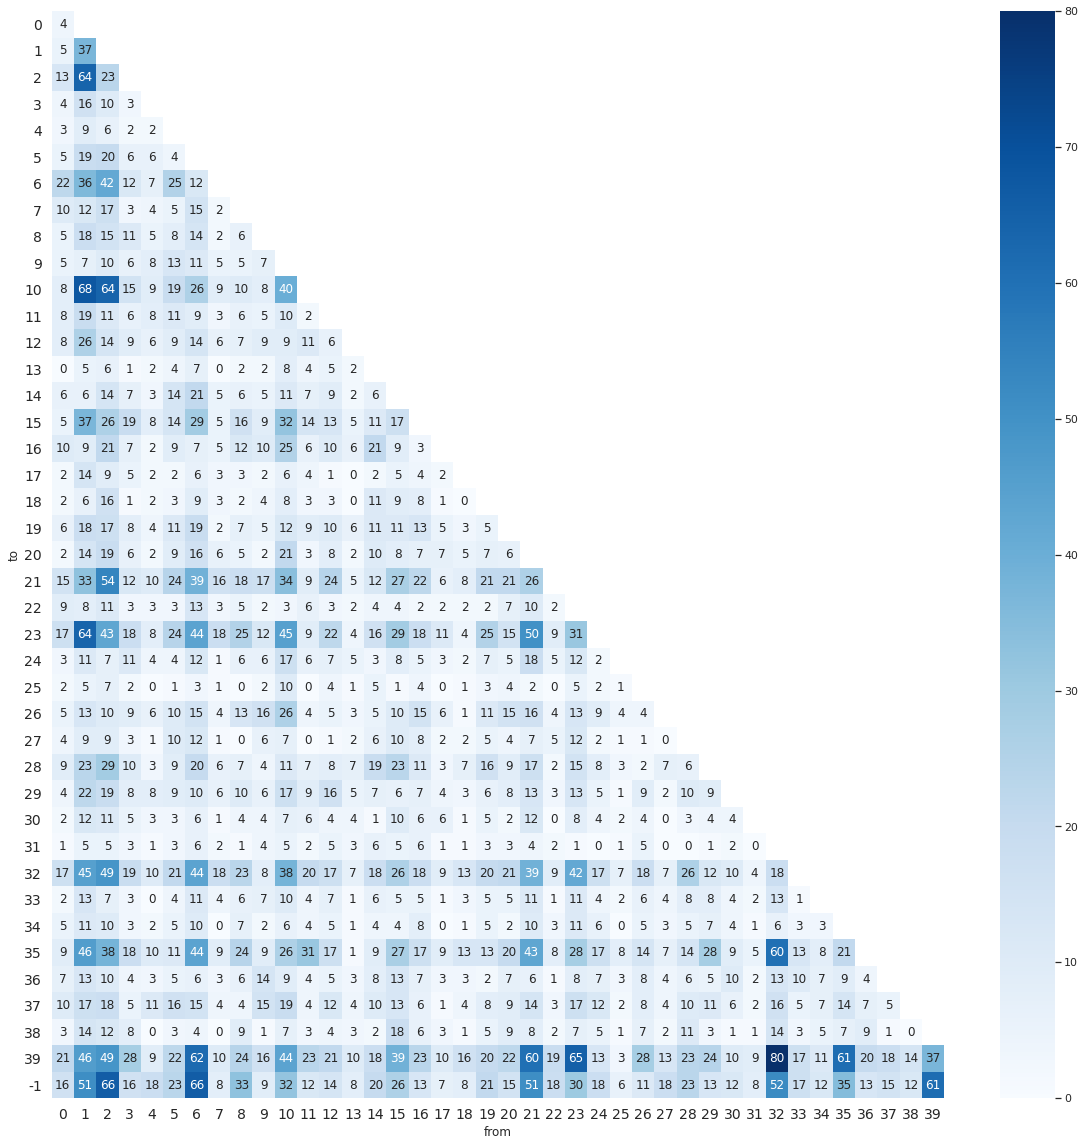

In [892]:
fig, ax = plt.subplots(figsize=(20,20)) 
mask = np.triu(np.ones_like(heatmap_df_.T, dtype=bool), 1)
b = sns.heatmap(heatmap_df_.T, mask=mask, cmap="Blues", annot=True)
b.tick_params(labelsize=14)
ax.tick_params(axis='y', rotation=0)
ax.set_facecolor("white")
plt.savefig('hands_non_flipped_combination_heatmap_.png', dpi=150)

### Prepare network

In [881]:
edge_df_ = pd.DataFrame(list(zip(from_, to_)),columns=['source', 'target']) #source #target

In [882]:
edge_df_ = edge_df_ .groupby(edge_df_ .columns.tolist(), as_index=False, dropna=False).size()
edge_df_.rename(columns = {'size':'weight_edge'}, inplace = True)

In [883]:
nodes = [[i, str(i)] for i in range(40)]
nodes.append(['-1', '-1'])

In [884]:
node_df = pd.DataFrame(nodes, columns = ['id', 'name'])
node_df.head(3)

,id,name
0,0,0
1,1,1
2,2,2


In [885]:
cluster_size = []
for i, row in node_df.iterrows():
    name = row['id']
    if name == '-1':
        cluster_size.append(int(1))
        continue
    total = int(df_hands_clusters['cluster'].value_counts()[name])
    cluster_size.append(total)

In [886]:
node_df['weight_cluster'] = cluster_size

In [893]:
#Now we need to normalize the weight given for each node
node_df['weight_cluster'] = min_max_scaling(node_df['weight_cluster'])

In [894]:
node_df.head(3)

,id,name,weight_cluster
0,0,0,26.356589
1,1,1,78.552972
2,2,2,82.945736


In [911]:
#Create the color palette to be used for the dges
color = []
n = len(df_hands_clusters['icon_name'].unique())

for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))
print(color)

['#C94C59', '#9CAA46', '#1A8263', '#985C6A', '#7A7A71', '#B084A9', '#79A51E', '#72DCC5', '#C804D0', '#AB9EA1', '#8D63A1', '#351DE5', '#900AB5', '#89EBA3', '#A3B7D4', '#9226BC', '#AE5815', '#6901FD', '#B499B5', '#18818C', '#A82BBC', '#494467', '#EA8453', '#DDBA89', '#D759FB', '#5E998F', '#605EF8', '#D4C269', '#61C61D', '#144D95', '#9C73DD', '#C3A9A1', '#440674', '#66398A', '#5B4CA7', '#47DC9F', '#40E754', '#CFEE7B', '#A794B4', '#B9B582', '#5F7059', '#13D261', '#50B4DE', '#8AD0F1', '#D2D3D1', '#4A8863', '#FD7D67', '#4D46C0', '#B63CF5', '#F868F4', '#CBAE4E', '#0FD6F6', '#264BBF', '#5C3536', '#7BECB7', '#FC2FBC', '#D47664']


In [895]:
from_string = map(str, from_)
to_string = map(str, to_)

In [896]:
edge_df_ = pd.DataFrame(list(zip(from_string, to_string, icon_, icon_name_)),columns=['source', 'target', 'icon', 'icon_name']) #source #target

In [897]:
edge_df_.head(3)

,source,target,icon,icon_name
0,6,19,11HH,female saints
1,35,-1,11H,saints
2,3,31,42,"family, descendance"


In [898]:
edge_df_ = edge_df_ .groupby(edge_df_ .columns.tolist(), as_index=False, dropna=False).size()
edge_df_.rename(columns = {'size':'weight_edge'}, inplace = True)

In [905]:
edge_df_.head(3)

,source,target,icon,icon_name,weight_edge
0,0,-1,11F,the Virgin Mary,3
1,0,-1,11H,saints,8
2,0,-1,12,non-Christian religions (including institution...,1


In [906]:
icon_name = edge_df_['icon_name'].unique().tolist()

In [915]:
createNetwork("icon_nx_clusters_non_flipped_hands_2_degree.html", node_df, edge_df_, img_path="KMEANS_features_alkashi_scaled_40_clusters/")

## Prepare data with Dimova categories
Here we mix the clusters with the categories from the art historian to visualize it as a network

In [953]:
df_hands_clusters_flipped

,hands,cluster,iconography,icon_name
0,bhim00037788_0_hand_right.jpg,26,11HH,female saints
1,bh012186_0_hand_right.jpg,5,11H,saints
2,bh013263_0_hand_right.jpg,36,11H,saints
3,bhim00037212_1_hand_right.jpg,33,42,"family, descendance"
4,bhim00037212_3_hand_right.jpg,24,42,"family, descendance"
...,...,...,...,...
5980,bhim00034316_11_hand_left.jpg,28,73,New Testament
5981,bhim00034390_1_hand_left.jpg,1,95,the Greek heroic legends (II)
5982,bh012270_0_hand_left.jpg,22,47,crafts and industries
5983,bh012893_0_hand_left.jpg,33,96,Roman gods and legends


In [972]:
#Get all the categories from Dimova and assign them later to the clusters
labels_ = []
hands_ = []
dim_cat = []
for root, subdirectories, files in os.walk('../ha_dimova_clustering_05_short_bh'):
    class_ = os.path.basename(os.path.normpath(root))
    if subdirectories:
        dim_cat = subdirectories
    for file in files:
        #class_ = os.path.basename(os.path.normpath(root))
        try: 
            hands_.append(file)
            labels_.append(class_)
        except:
            continue

In [973]:
print(len(labels_), len(hands_))

1398 1398


In [991]:
dim_cat_ = [[cat]+[''.join(s[0] for s in cat.split())] for cat in dim_cat]

In [992]:
dim_cat_

[['benedictio', 'b'],
 ['pointing index', 'pi'],
 ['fist', 'f'],
 ['opened hand forward', 'ohf'],
 ['opened hand up', 'ohu'],
 ['joint palms praying', 'jpp'],
 ['hand on chest', 'hoc'],
 ['opened palm forward', 'opf'],
 ['intertwined fingers', 'if']]

In [1006]:
df_hands_clusters_flipped_dim = df_hands_clusters_flipped.copy()

In [1007]:
df_hands_clusters_flipped_dim['cluster'] = df_hands_clusters_flipped_dim['cluster'].astype(str)

In [1008]:
for i, row in df_hands_clusters_flipped.iterrows():
    a_hand = row['hands']
    if a_hand in hands_ :
        index_ = hands_.index(a_hand)
        new_icon = labels_[index_]
        #icon_ref = [y[0] for y in dim_cat_].index(new_icon)
        df_hands_clusters_flipped_dim.at[i, 'cluster'] = new_icon
        #df_hands_clusters_flipped_dim.at[i, 'iconography'] = icon_ref

In [1009]:
df_hands_clusters_flipped_dim.head(5)

,hands,cluster,iconography,icon_name
0,bhim00037788_0_hand_right.jpg,26,11HH,female saints
1,bh012186_0_hand_right.jpg,5,11H,saints
2,bh013263_0_hand_right.jpg,36,11H,saints
3,bhim00037212_1_hand_right.jpg,33,42,"family, descendance"
4,bhim00037212_3_hand_right.jpg,24,42,"family, descendance"


In [1081]:
#df_hands_clusters_flipped_dim.to_csv('df_hands_clusters_flipped_dim.csv')

### Prepare hands combination

In [1014]:
hands_combination = createHandsCombination(df_hands_clusters_flipped_dim)

In [1015]:
from_, to_, icon_, icon_name_ = prepareNetwork(hands_combination, df_hands_clusters_flipped_dim)

In [1016]:
df_combinations_simple = pd.DataFrame({'from': from_, 'to': to_})

### Plot heatmap

In [1018]:
counter_df_ = df_combinations_simple.groupby(df_combinations_simple.columns.tolist(), as_index=False, dropna=False).size()
counter_df_ = counter_df_.fillna('None')
heatmap_df_ = counter_df_.pivot_table(index='from', columns='to', values='size', fill_value=0, dropna=False)

In [1124]:
counter_df_.sort_values(by=['size']).tail(30)

,from,to,size
1126,8,8,33
761,26,8,34
944,33,-1,34
1136,8,pointing index,34
1186,opened hand forward,-1,34
966,33,pointing index,35
1185,joint palms praying,pointing index,36
42,1,-1,36
1199,pointing index,pointing index,37
391,17,17,37


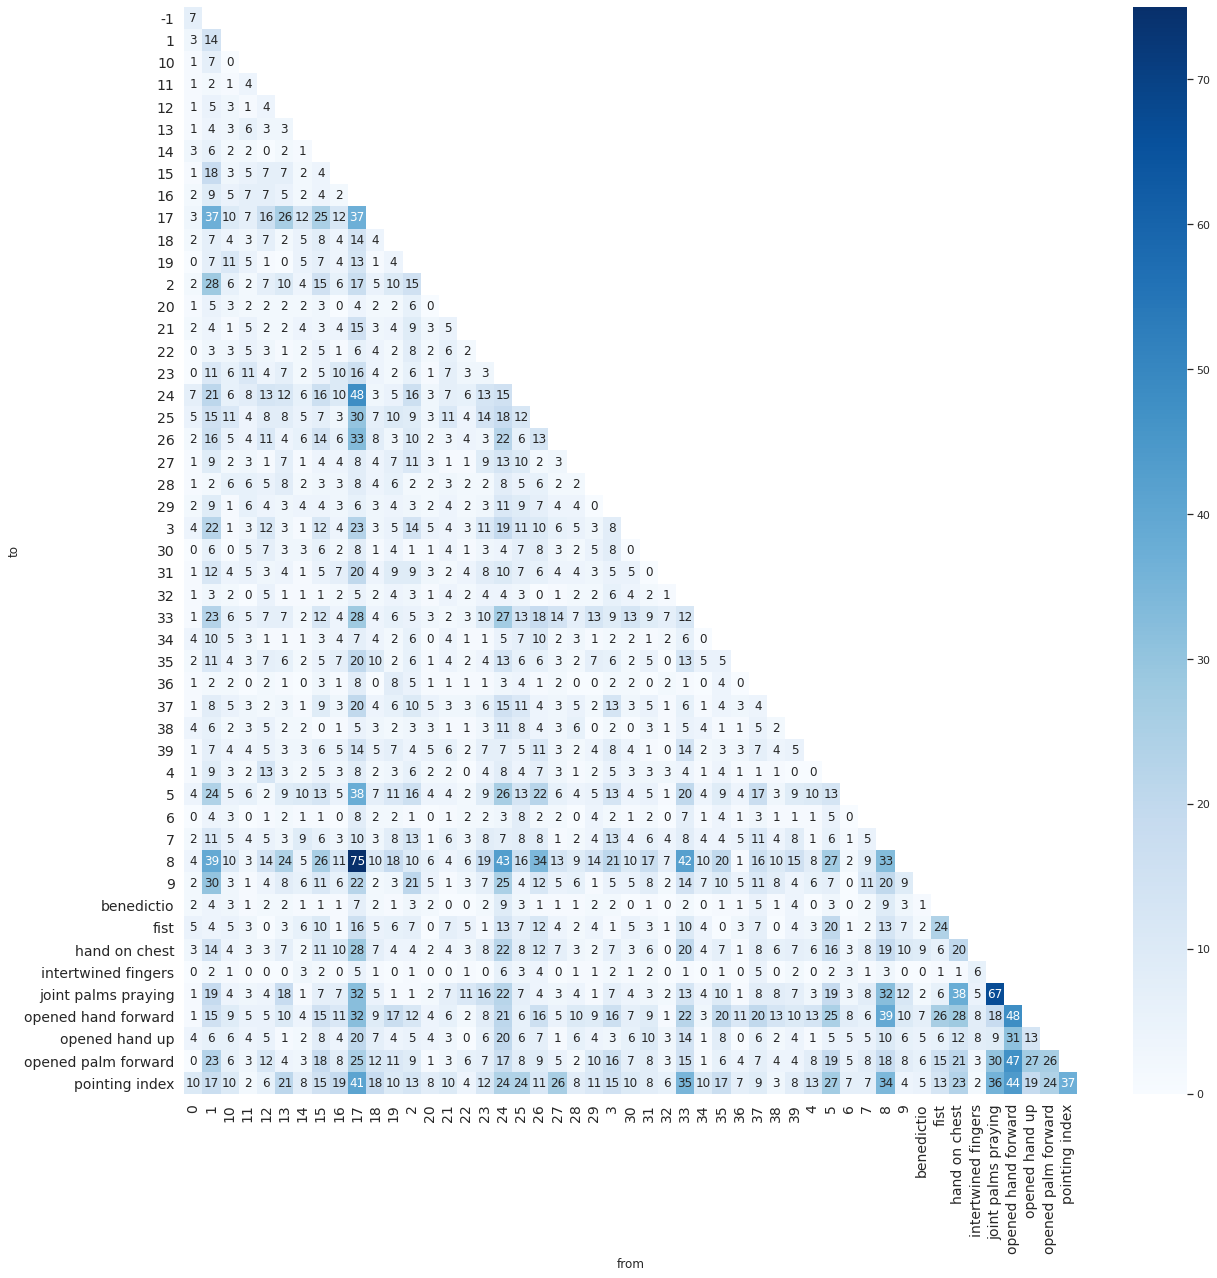

In [1023]:
fig, ax = plt.subplots(figsize=(20,20)) 
mask = np.triu(np.ones_like(heatmap_df_.T, dtype=bool), 1)
b = sns.heatmap(heatmap_df_.T, mask=mask, cmap="Blues", annot=True)
b.tick_params(labelsize=14)
ax.tick_params(axis='y', rotation=0)
ax.set_facecolor("white")
plt.savefig('hands_flipped_dm_combination_heatmap_.png', dpi=150)

### Prepare network

In [1024]:
edge_df_ = pd.DataFrame(list(zip(from_, to_)),columns=['source', 'target']) #source #target

In [1025]:
edge_df_ = edge_df_ .groupby(edge_df_ .columns.tolist(), as_index=False, dropna=False).size()
edge_df_.rename(columns = {'size':'weight_edge'}, inplace = True)

In [1040]:
clusters_ = list(df_hands_clusters_flipped_dim['cluster'].unique())

In [1041]:
clusters_.sort()

In [1050]:
nodes = []
counter = 0
for i in clusters_ :
    try:
        nodes.append([int(i), str(i)])
    except:
        nodes.append([counter, i])
    counter += 1 
nodes.append(['-1', '-1'])

In [1075]:
nodes

[[0, '0'],
 [1, '1'],
 [10, '10'],
 [11, '11'],
 [12, '12'],
 [13, '13'],
 [14, '14'],
 [15, '15'],
 [16, '16'],
 [17, '17'],
 [18, '18'],
 [19, '19'],
 [2, '2'],
 [20, '20'],
 [21, '21'],
 [22, '22'],
 [23, '23'],
 [24, '24'],
 [25, '25'],
 [26, '26'],
 [27, '27'],
 [28, '28'],
 [29, '29'],
 [3, '3'],
 [30, '30'],
 [31, '31'],
 [32, '32'],
 [33, '33'],
 [34, '34'],
 [35, '35'],
 [36, '36'],
 [37, '37'],
 [38, '38'],
 [39, '39'],
 [4, '4'],
 [5, '5'],
 [6, '6'],
 [7, '7'],
 [8, '8'],
 [9, '9'],
 [40, 'benedictio'],
 [41, 'fist'],
 [42, 'hand on chest'],
 [43, 'intertwined fingers'],
 [44, 'joint palms praying'],
 [45, 'opened hand forward'],
 [46, 'opened hand up'],
 [47, 'opened palm forward'],
 [48, 'pointing index'],
 ['-1', '-1']]

In [1052]:
node_df = pd.DataFrame(nodes, columns = ['id', 'name'])
node_df.head(3)

,id,name
0,0,0
1,1,1
2,10,10


In [1054]:
cluster_size = []
for i, row in node_df.iterrows():
    name = row['name']
    if name == '-1':
        cluster_size.append(int(1))
        continue
    total = int(df_hands_clusters_flipped_dim['cluster'].value_counts()[name])
    cluster_size.append(total)

In [1105]:
node_df['weight_cluster'] = cluster_size

In [1106]:
#Now we need to normalize the weight given for each node
node_df['weight_cluster'] = min_max_scaling(node_df['weight_cluster'])

In [1107]:
node_df.head(3)

,id,name,weight_cluster
0,0,0,9.917355
1,1,1,60.881543
2,10,10,20.661157


In [1108]:
#Create the color palette to be used for the dges
color = []
n = len(df_hands_clusters_flipped_dim['icon_name'].unique())

for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))
print(color)

['#3B403A', '#DABC6A', '#4C8A4A', '#9C1541', '#C8E2BE', '#5B0B5B', '#4EF33B', '#2A7F16', '#1DDF28', '#C39D51', '#39178F', '#99D34D', '#163CEE', '#001F26', '#A4E180', '#982EF7', '#0806D4', '#5BCB13', '#1CD207', '#35B7F3', '#3776F0', '#D8FCA0', '#8167AF', '#820FD0', '#CC094D', '#18A13A', '#5C8180', '#42137F', '#9A89DE', '#D50A71', '#DBCBD2', '#5895EF', '#2DD518', '#E0B17E', '#FD3D32', '#E4FAFE', '#D11545', '#E2FB56', '#8C091B', '#0125DB', '#F722A3', '#1307DB', '#071A17', '#BC95D7', '#2B7118', '#5B0554', '#D0A0F4', '#6B7878', '#EF7314', '#EA40F0', '#E4496B', '#9B6D89', '#A463F1', '#54AE30', '#AE3E06', '#5E826D', '#986F4F']


In [1118]:
import colorsys
#Here we create brighter colors

n = len(df_hands_clusters_flipped_dim['icon_name'].unique())
rgbs = []
for iteration in range(n):
    h,s,l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
    rgb = [int(256*i) for i in colorsys.hls_to_rgb(h,l,s)]
    rgbs.append(rgb)

color = ["".join('#{:02x}{:02x}{:02x}'.format(r, g, b)) for [r,g,b] in rgbs]
print(color)

['#fb5128', '#2d83b3', '#c02c71', '#992fc8', '#1c24b0', '#28fa68', '#4e51d1', '#3cbbad', '#561ac4', '#259aab', '#ee3ab0', '#22c7ab', '#a807d9', '#0e87d3', '#ea6636', '#4b59e7', '#37a9af', '#7f02d7', '#cb7125', '#eb0426', '#34bf14', '#38f39a', '#3de553', '#e13664', '#7828c7', '#da05c1', '#22b4bc', '#dd15f3', '#e413bb', '#a13048', '#4fddc6', '#3066dd', '#06de64', '#aaf20a', '#c8b248', '#37ac49', '#4486d3', '#bd33a2', '#c234b4', '#b36333', '#8034ae', '#cd0736', '#1ed3d7', '#5cccc6', '#da53d3', '#931cd2', '#e5622b', '#20de56', '#85f732', '#480eca', '#4ce031', '#04f26e', '#0dcd0c', '#0dfa62', '#b12998', '#7931be', '#66dc2d']


In [1109]:
from_string = map(str, from_)
to_string = map(str, to_)

In [1110]:
edge_df_ = pd.DataFrame(list(zip(from_string, to_string, icon_, icon_name_)),columns=['source', 'target', 'icon', 'icon_name']) #source #target

In [1111]:
edge_df_ = edge_df_ .groupby(edge_df_ .columns.tolist(), as_index=False, dropna=False).size()
edge_df_.rename(columns = {'size':'weight_edge'}, inplace = True)

In [1112]:
icon_name = edge_df_['icon_name'].unique().tolist()

In [1119]:
createNetwork("icon_nx_clusters_flipped_dm_hands_2_degree.html", node_df, edge_df_, img_path="KMEANS_features_alkashi_scaled_flipped_40_clusters/", flipped =True)